In [6]:
import pandas as pd
url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/'+'master/dataset/HAR_dataset/features.txt'

feature_name_df = pd.read_csv(url, sep='\s+', header=None, 
                             names=['column_index' , 'column_name'])
feature_name = feature_name_df.iloc[:, 1].values.tolist()
X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/' + 'master/dataset/HAR_dataset/train/X_train.txt'

X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/' +'master/dataset/HAR_dataset/test/X_test.txt'

X_train = pd.read_csv(X_train_url, sep='\s+', header=None)
X_test = pd.read_csv(X_test_url, sep='\s+', header=None)
X_train.columns = feature_name
X_test.columns = feature_name

y_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/' + 'master/dataset/HAR_dataset/train/y_train.txt'
y_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/' +'master/dataset/HAR_dataset/test/y_test.txt'

y_train = pd.read_csv(y_train_url, sep='\s+', header=None, names=['action'])
y_test = pd.read_csv(y_test_url, sep='\s+', header=None, names=['action'])

y_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 1), (2947, 561), (7352, 1), (2947, 1))

In [9]:
from sklearn.decomposition import PCA

def get_pca_data(ss_data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)
    
    return pca.transform(ss_data), pca

In [10]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pca.shape

(7352, 2)

In [11]:
cols = ['pca_'+str(n) for n in range(pca.components_.shape[0])]
cols

['pca_0', 'pca_1']

In [17]:
def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_'+str(n) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

In [18]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
HAR_pd_pca.head()

,pca_0,pca_1,action
0,-5.520280,-0.290278,5
1,-5.535350,-0.082530,5
2,-5.474988,0.287387,5
3,-5.677232,0.897031,5
4,-5.748749,1.162952,5


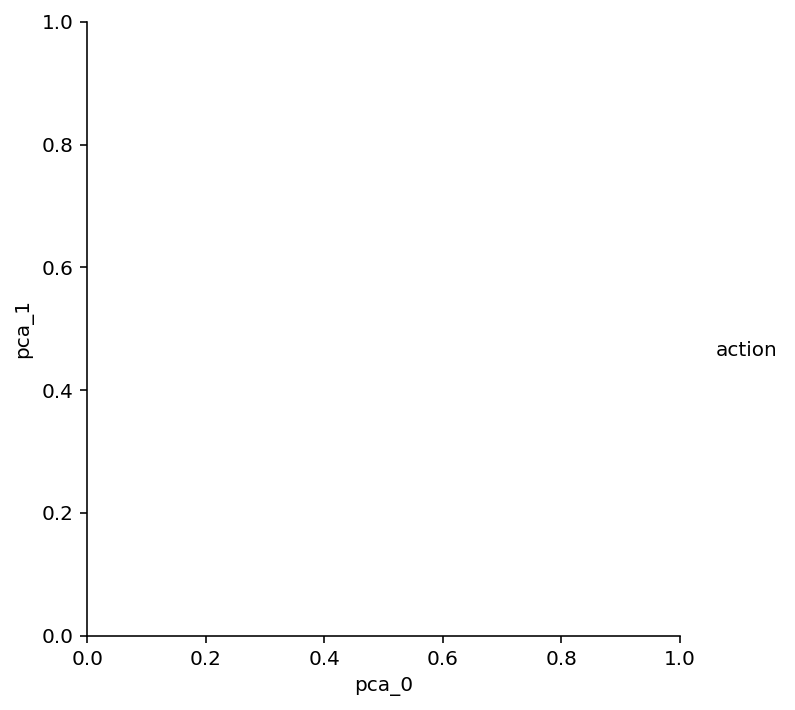

In [19]:
import seaborn as sns
sns.pairplot(HAR_pd_pca, hue='action', height=5,
            x_vars=['pca_0'], y_vars=['pca_1']);

In [22]:
import numpy as np

def print_variance_ratio(pca):
    print('variance_ratio: ', pca. explained_variance_ratio_)
    print('sum of variance_ratio: ', np.sum(pca.explained_variance_ratio_))
    
print_variance_ratio(pca)

variance_ratio:  [0.6255444  0.04913023]
sum of variance_ratio:  0.6746746270487948


In [23]:
HAR_pca, pca = get_pca_data(X_train, n_components=10)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train

print_variance_ratio(pca)

variance_ratio:  [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.00969379 0.00858009]
sum of variance_ratio:  0.8050386075174512


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth' : [6, 8, 10],
    'n_estimators' : [50, 100, 200],
    'min_samples_leaf' : [8, 12],
    'min_samples_split' : [8, 12],
    }
rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(HAR_pca, y_train.values.reshape(-1,))

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200]})

In [27]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[target_col].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
17,1,0.838003,200,8
14,1,0.838003,200,8
29,3,0.837595,200,10
26,3,0.837595,200,10
28,5,0.836779,100,10


In [28]:
grid_cv.best_params_

{'max_depth': 8,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 200}

In [29]:
grid_cv.best_score_

0.8380032644178455

In [30]:
from sklearn.metrics import accuracy_score

rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(HAR_pca, y_train.values.reshape(-1,))

pred1 = rf_clf_best.predict(pca.transform(X_test))

accuracy_score(y_test , pred1)

0.8527315914489311

In [32]:
import time
from xgboost import XGBClassifier

evals = [(pca.transform(X_test), y_test)]

start_time = time.time()
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(HAR_pca, y_train.values.reshape(-1,),
       early_stopping_rounds=10, eval_set=evals)
print('Fit time : ', time.time() - start_time)

[0]	validation_0-merror:0.224975
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.221581
[2]	validation_0-merror:0.204276


c:\users\oaqqa\anaconda3\envs\dss15\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[3]	validation_0-merror:0.203597
[4]	validation_0-merror:0.201561
[5]	validation_0-merror:0.202579
[6]	validation_0-merror:0.195792
[7]	validation_0-merror:0.19681
[8]	validation_0-merror:0.192738
[9]	validation_0-merror:0.191381
[10]	validation_0-merror:0.189345
[11]	validation_0-merror:0.18697
[12]	validation_0-merror:0.185273
[13]	validation_0-merror:0.183237
[14]	validation_0-merror:0.181201
[15]	validation_0-merror:0.178487
[16]	validation_0-merror:0.177808
[17]	validation_0-merror:0.176451
[18]	validation_0-merror:0.174415
[19]	validation_0-merror:0.176111
[20]	validation_0-merror:0.174754
[21]	validation_0-merror:0.174415
[22]	validation_0-merror:0.173736
[23]	validation_0-merror:0.174754
[24]	validation_0-merror:0.174075
[25]	validation_0-merror:0.175772
[26]	validation_0-merror:0.173397
[27]	validation_0-merror:0.172379
[28]	validation_0-merror:0.171021
[29]	validation_0-merror:0.171021
[30]	validation_0-merror:0.171361
[31]	validation_0-merror:0.170682
[32]	validation_0-merro

In [33]:
accuracy_score(y_test, xgb.predict(pca.transform(X_test)))

0.8666440447913132

In [2]:
df_train = pd.read_csv('data/mnist_train.csv')
df_test = pd.read_csv('data/mnist_test.csv')

df_train.shape, df_test.shape

((60000, 785), (10000, 785))

In [3]:
import pandas as pd

In [4]:
import numpy as np

X_train = np.array(df_train.iloc[:, 1:])
y_train = np.array(df_train['label'])

X_test = np.array(df_test.iloc[:, 1:])
y_test = np.array(df_test['label'])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [5]:
import random

samples = random.choices(population=range(0, 60000), k=16)
samples

[45445,
 47888,
 14574,
 49679,
 5779,
 28902,
 54066,
 48592,
 1758,
 42435,
 15952,
 6028,
 55702,
 43129,
 46262,
 29025]

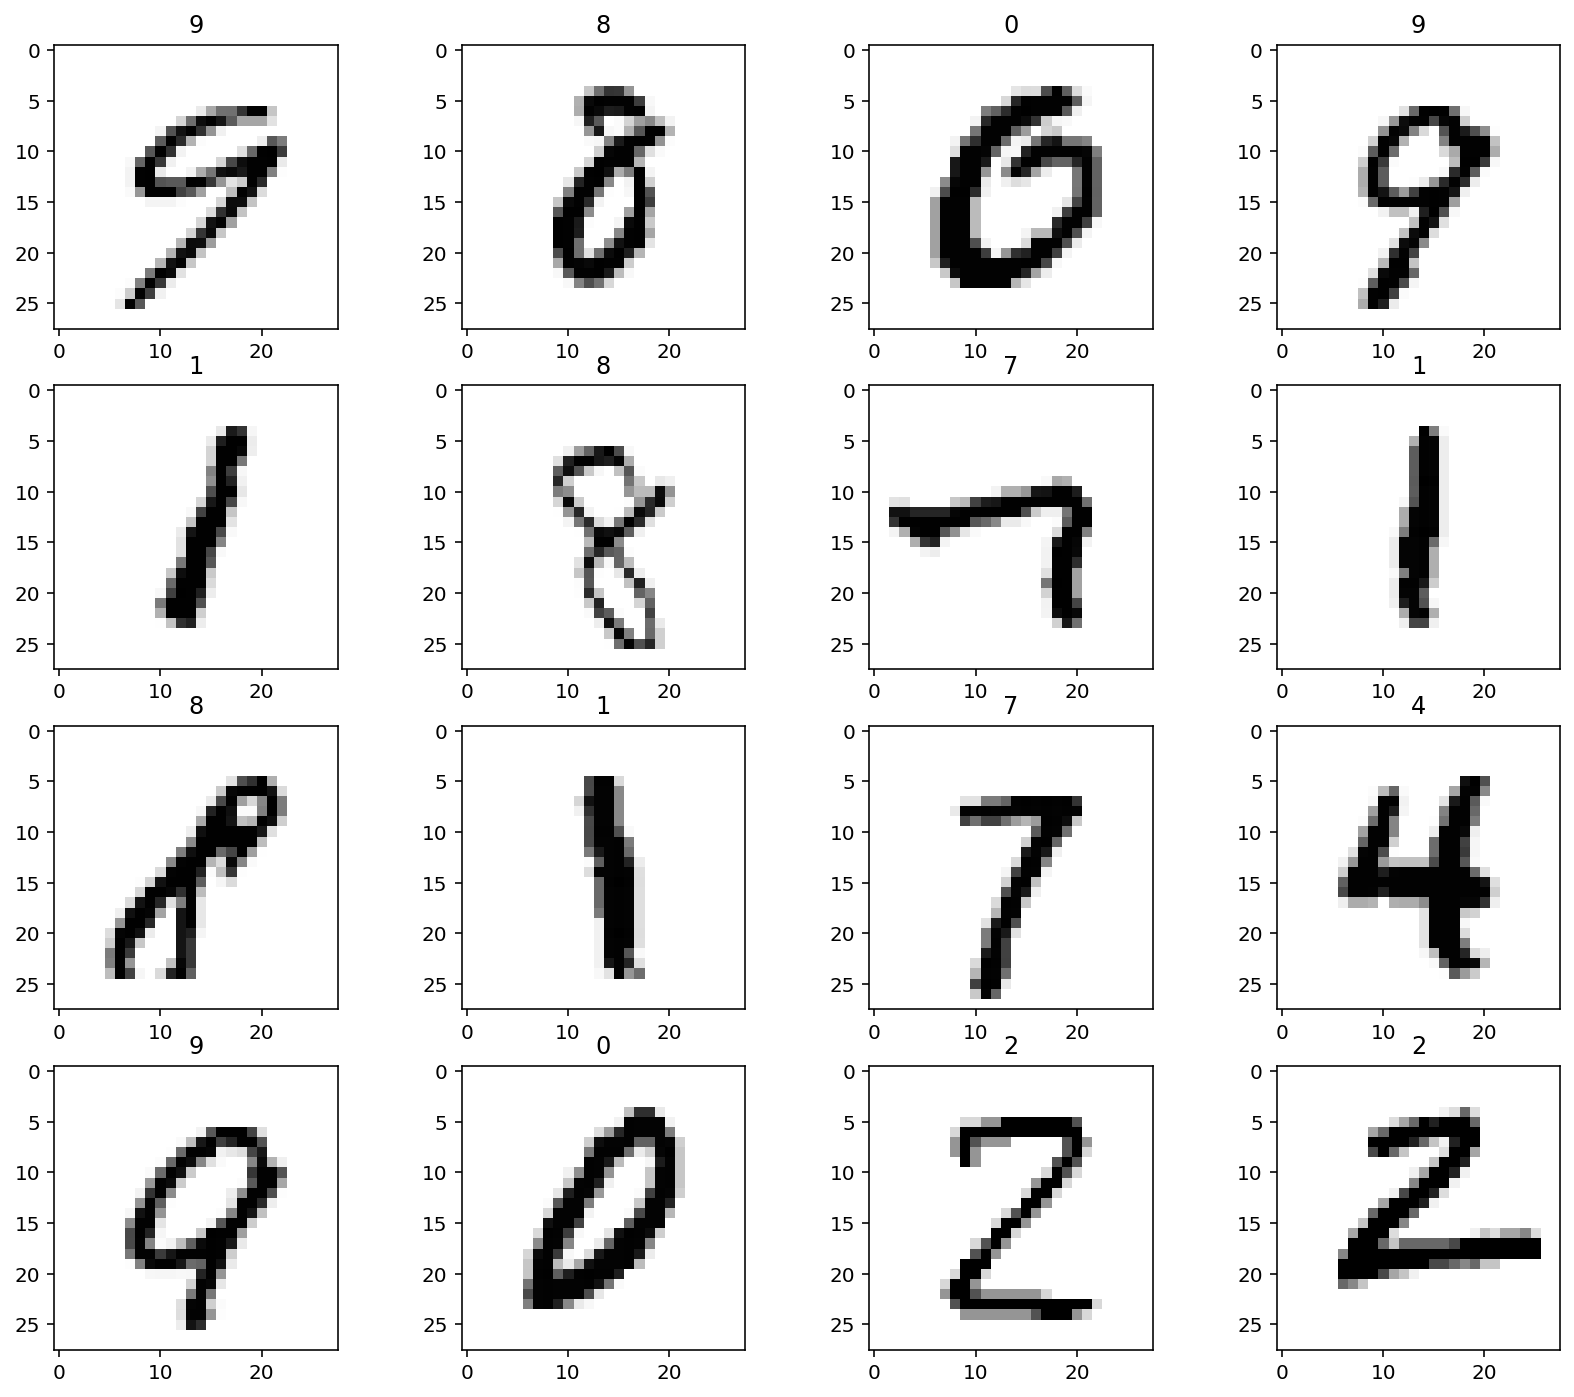

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,12))

for idx, n in enumerate(samples):
    plt.subplot(4, 4, idx+1)
    plt.imshow(X_train[n].reshape(28,28), cmap='Greys', interpolation='nearest')
    plt.title(y_train[n])
    
plt.show()

In [7]:
from sklearn.neighbors import KNeighborsClassifier
import time

start_time = time.time()
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
print('Fit time : ', time.time() - start_time)

Fit time :  106.12767696380615


In [8]:
from sklearn.metrics import accuracy_score

start_time = time.time()
pred = clf.predict(X_test)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Fit time :  1274.4921190738678
0.9688


In [9]:
from sklearn.neighbors import KNeighborsClassifier
import time

start_time = time.time()
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
print('Fit time : ', time.time() - start_time)

Fit time :  67.82998418807983


In [16]:
from sklearn.metrics import accuracy_score

start_time = time.time()
pred = clf.predict(X_test)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Fit time :  1018.8431351184845
0.9688


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ('pca', PCA()),
    ('clf', KNeighborsClassifier()),
])

parameters = {
    'pca__n_components' : [2, 5, 10],
    'clf__n_neighbors' : [5, 10, 15]
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
grid = GridSearchCV(pipe, parameters, cv=kf, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [5, 10, 15],
                         'pca__n_components': [2, 5, 10]},
             verbose=1)

In [23]:
print("BEst score: %0.3f" % grid.best_score_)
print("best parameters set:")
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

BEst score: 0.931
best parameters set:
	clf__n_neighbors: 10
	pca__n_components: 10


In [24]:
accuracy_score(y_test, grid.best_estimator_.predict(X_test))

0.9291

In [26]:
def results(y_pred, y_test):
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_test, y_pred))
    
results(grid.predict(X_train), y_train)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5923
           1       0.98      0.99      0.98      6742
           2       0.96      0.96      0.96      5958
           3       0.94      0.90      0.92      6131
           4       0.94      0.93      0.93      5842
           5       0.93      0.94      0.93      5421
           6       0.96      0.98      0.97      5918
           7       0.96      0.95      0.96      6265
           8       0.92      0.91      0.91      5851
           9       0.90      0.91      0.90      5949

    accuracy                           0.95     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.95      0.94     60000



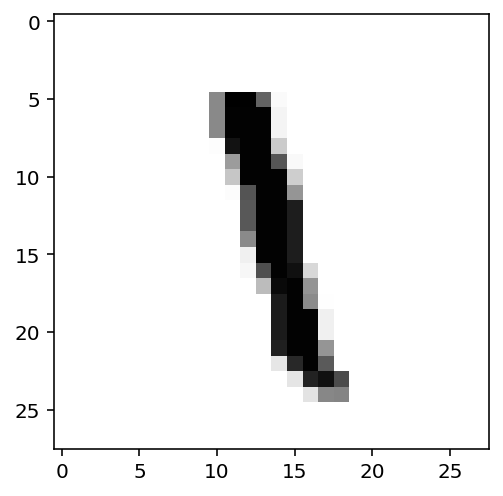

Answer is :  [1]


In [28]:
n = 700
plt.imshow(X_test[n].reshape(28,28), cmap='Greys', interpolation='nearest')
plt.show()

print('Answer is : ', grid.best_estimator_.predict(X_test[n].reshape(1,784)))

In [29]:
preds = grid.best_estimator_.predict(X_test)
preds

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [30]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

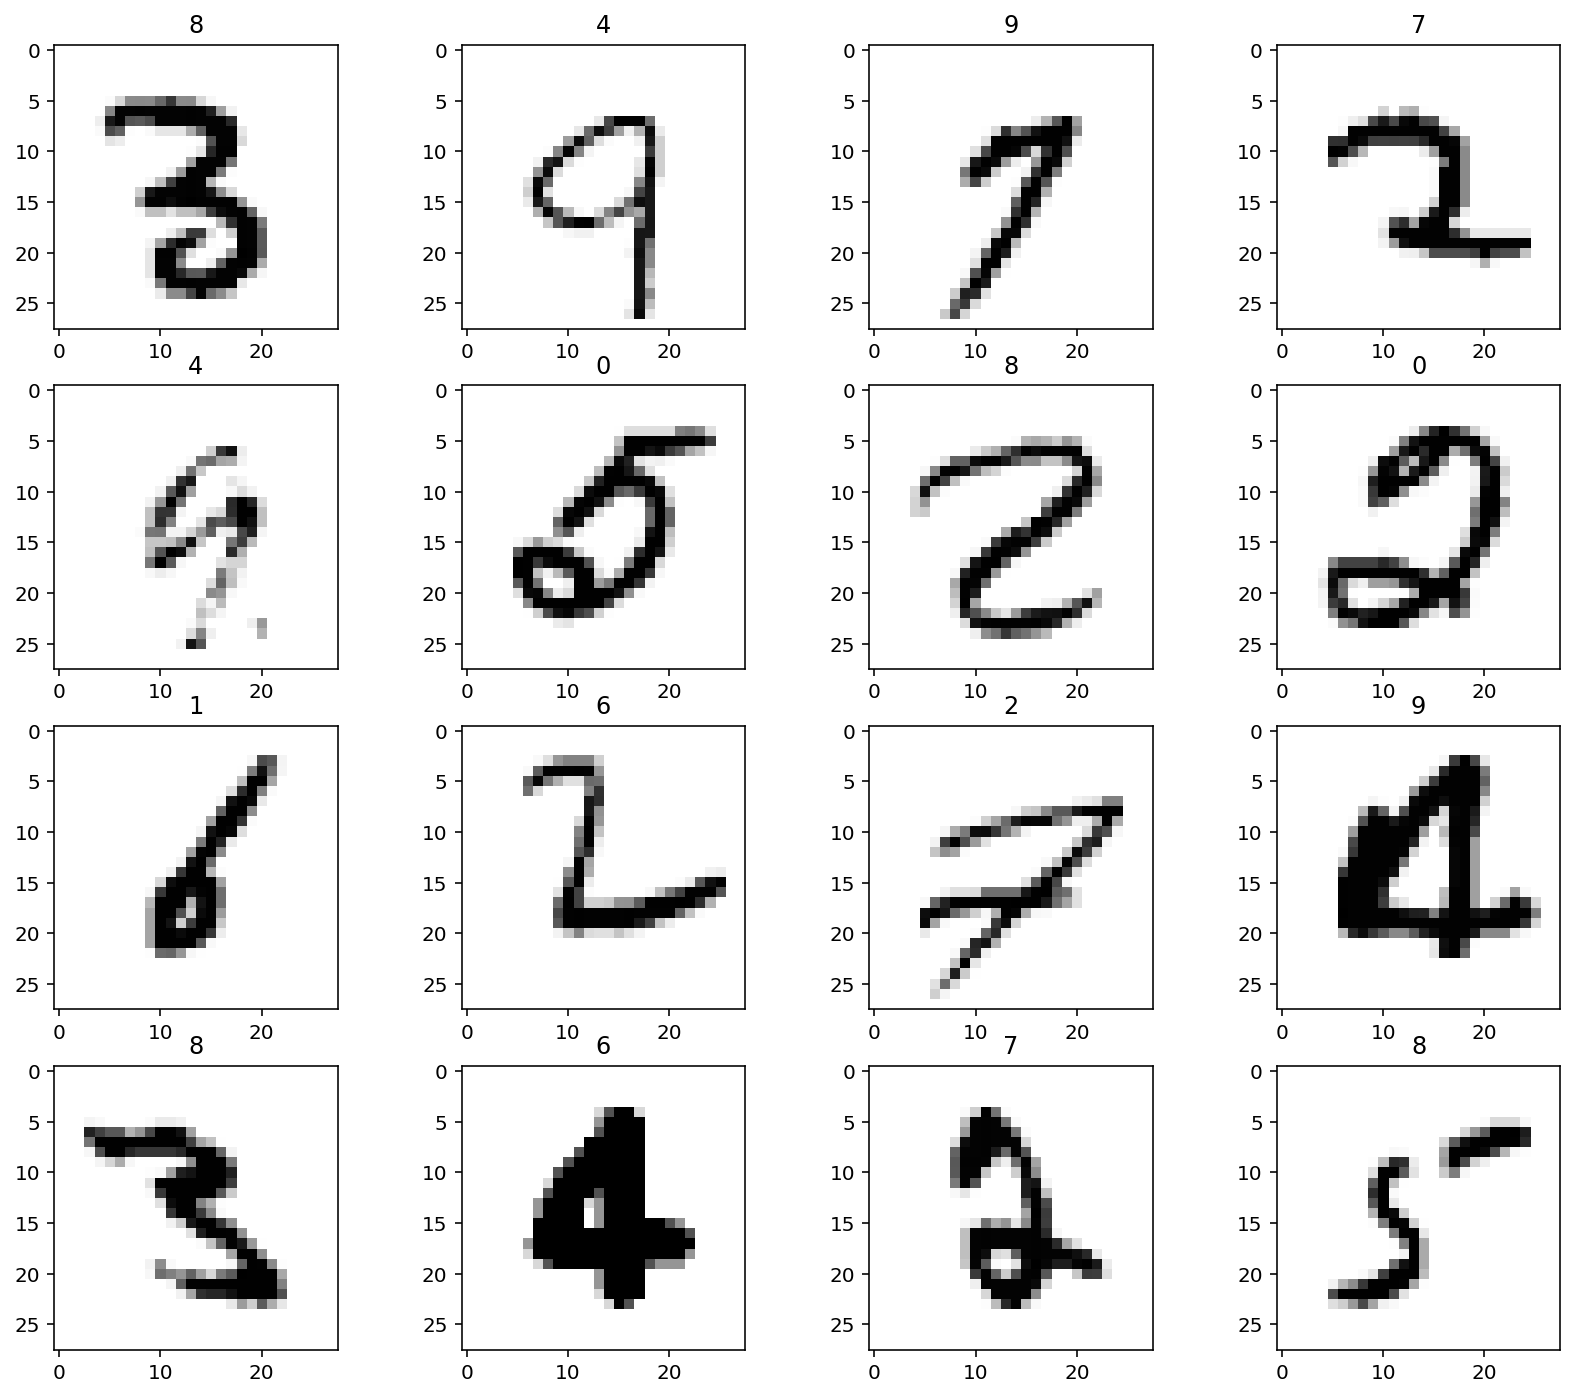

In [35]:
wrong_results = X_test[y_test != preds]
samples = random.choices(population=range(0, wrong_results.shape[0]), k=16)

plt.figure(figsize=(14,12))

for idx, n in enumerate(samples):
    plt.subplot(4, 4, idx+1)
    plt.imshow(wrong_results[n].reshape(28,28), cmap='Greys', interpolation='nearest')
    plt.title(grid.best_estimator_.predict(wrong_results[n].reshape(1, 784))[0])
    
plt.show()